
# Assignment #2, 11/28/2018

### Captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.



In [328]:
import pandas as pd
import os
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot # for plotting model fits

import numpy as np
%matplotlib inline




## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

In [228]:
# Download Local Law 84 Data here
# puidata = os.getenv("PUIDATA")
# pluto_url = 'https://data.cityofnewyork.us/resource/m46j-75iy.csv?borough=Manhattan'
# filename = pluto_url.split('/')[-1]
# newname = 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv'

# os.system('curl -O '+pluto_url)
# os.system('mv ' + filename + ' ' + newname )
# os.system("mv " + newname + " " + puidata)

In [229]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv")

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO/MNMapPLUTO.shp")

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


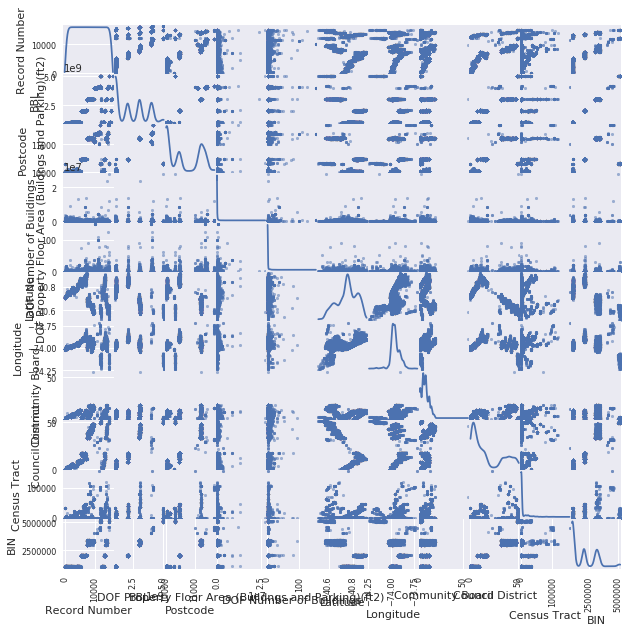

In [230]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

Figure 1: The plot shows that there are high correlations associated with latitude and longitude values, which are meaningless since those two variables are defined against each other.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [231]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [232]:
nrg = nrg[['BBL','Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)']]

nrg.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Reported Property Floor Area'},
          inplace=True)
nrg['BBL'] = nrg.BBL.astype(float)

In [233]:
bsize = bsize[['BBL','UnitsTotal','YearBuilt','UnitsRes','geometry']]

In [234]:
#leave
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [235]:
#leave
bsize.head()

,BBL,UnitsTotal,YearBuilt,UnitsRes,geometry
0,1.015450e+09,18,1920,16,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,1.007238e+09,50,1914,50,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,1.016800e+09,10,1910,10,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,1.013850e+09,32,1928,29,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,1.011970e+09,26,1900,26,"POLYGON ((992273.6849975586 224863.4904174805,..."


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


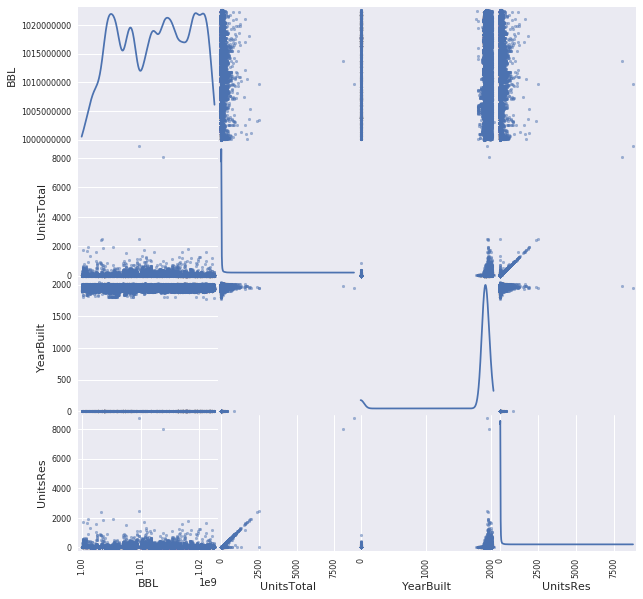

In [236]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

Figure 2: This plot shows that there's a high correlation between UnitsTotal and UnitsRes.

## Converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [237]:
nrg['Site EUI(kBtu/ft2)']= nrg['Site EUI(kBtu/ft2)'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
nrg['Reported Property Floor Area']= nrg['Reported Property Floor Area'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
bsize.dtypes, nrg.dtypes

(BBL           float64
 UnitsTotal      int64
 YearBuilt       int64
 UnitsRes        int64
 geometry       object
 dtype: object, BBL                             float64
 Site EUI(kBtu/ft2)              float64
 Reported Property Floor Area    float64
 dtype: object)

In [238]:
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [239]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [240]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## Merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [241]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = bsize.merge(nrg,on='BBL')
bblnrgdata = nrg.merge(bsize,on='BBL')
bblnrgdata.drop('geometry',axis=1,inplace=True)
bblnrgdataGPD.dropna(axis=0,inplace=True) # am i supposed to be doing this?
bblnrgdata.dropna(axis=0,inplace=True)

# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [242]:
#drop where no units or energy, can't take null of 0
bblnrgdataGPD = bblnrgdataGPD[bblnrgdataGPD.UnitsTotal != 0] 
bblnrgdataGPD = bblnrgdataGPD = bblnrgdataGPD[bblnrgdataGPD['Site EUI(kBtu/ft2)'] != 0]

#calculate log of each
bblnrgdataGPD['logarea'] = np.log(bblnrgdataGPD['Reported Property Floor Area'])
bblnrgdataGPD['lognrg'] = np.log(bblnrgdataGPD['Site EUI(kBtu/ft2)'])
bblnrgdataGPD['logunits'] = np.log(bblnrgdataGPD['UnitsTotal'])

bblnrgdataGPD.describe()

,BBL,UnitsTotal,YearBuilt,UnitsRes,Site EUI(kBtu/ft2),Reported Property Floor Area,logarea,lognrg,logunits
count,4.977000e+03,4977.000000,4977.000000,4977.000000,4.977000e+03,4.977000e+03,4977.000000,4977.000000,4977.000000
mean,1.012036e+09,114.056460,1941.602572,101.208358,1.145721e+03,2.129884e+05,11.831439,4.418027,3.878876
std,5.512745e+06,260.480753,69.347577,257.721850,4.311004e+04,3.239642e+05,0.826016,0.848972,1.544412
min,1.000048e+09,1.000000,0.000000,0.000000,1.000000e-01,2.700000e+03,7.901007,-2.302585,0.000000
25%,1.008280e+09,28.000000,1920.000000,0.000000,6.610000e+01,7.203000e+04,11.184838,4.191169,3.332205
50%,1.012398e+09,64.000000,1930.000000,56.000000,8.300000e+01,1.158640e+05,11.660172,4.418841,4.158883
75%,1.015160e+09,125.000000,1965.000000,115.000000,1.040000e+02,2.180910e+05,12.292668,4.644391,4.828314
max,1.022500e+09,8812.000000,2016.000000,8764.000000,3.018493e+06,9.515627e+06,16.068446,14.920268,9.083870


In [243]:
def removeOutliers(df,column):
    mean = df[column].mean()
    std = df[column].std()
    return(df[(df[column] > mean - (3 * std)) & (df[column] < mean + (3 * std))])

In [244]:
# bblnrgdataGPD = removeOutliers(bblnrgdataGPD,'lognrg')
# bblnrgdataGPD = removeOutliers(bblnrgdataGPD,'logunits')
# len(bblnrgdataGPD)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(977413.35317382822, 1011284.188208008, 191684.49734802247, 261826.39004211425)

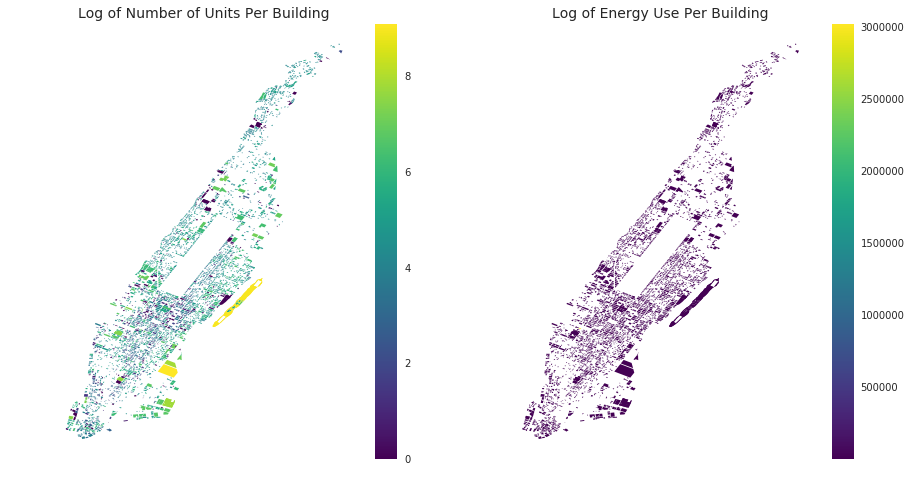

In [245]:
plt.figure(figsize=(15,8))

ax = plt.subplot(121)
plt.title('Log of Number of Units Per Building', fontsize = 14)
bblnrgdataGPD.plot(column='logunits',
                   cmap='viridis', 
                   ax=ax, 
                   legend=True)
plt.axis('off')

ax2 = plt.subplot(122)
plt.title('Log of Energy Use Per Building', fontsize = 14)
bblnrgdataGPD.plot(column='Site EUI(kBtu/ft2)',
                   cmap='viridis', 
                   ax=ax2, 
                   legend=True)
plt.axis('off')

**Figure 3:** After normalizing the data by taking the log of each variable of concern, we see that number of units (left) varies greatly over Manhattan while energy use (right) appears to be consistent with a few outliers. Notice that the data was cleaned up by dropping 0 values and eliminating outliers (builidings that fell beyond or below 3 standard deviations)

# Feature engineering

In [246]:
bblnrgdata.describe()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area,UnitsTotal,YearBuilt,UnitsRes
count,5.039000e+03,5.039000e+03,5.039000e+03,5039.000000,5039.000000,5039.000000
mean,1.012012e+09,1.157288e+03,2.144382e+05,112.655090,1935.055368,99.963088
std,5.513629e+06,4.287661e+04,3.248343e+05,259.177366,132.043889,256.374053
min,1.000048e+09,0.000000e+00,1.000000e+03,0.000000,0.000000,0.000000
25%,1.008265e+09,6.590000e+01,7.206400e+04,27.000000,1920.000000,0.000000
50%,1.012370e+09,8.300000e+01,1.160000e+05,63.000000,1930.000000,55.000000
75%,1.015150e+09,1.041000e+02,2.207000e+05,123.000000,1965.000000,113.000000
max,1.022500e+09,3.018493e+06,9.515627e+06,8812.000000,2016.000000,8764.000000


(0, 1000)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


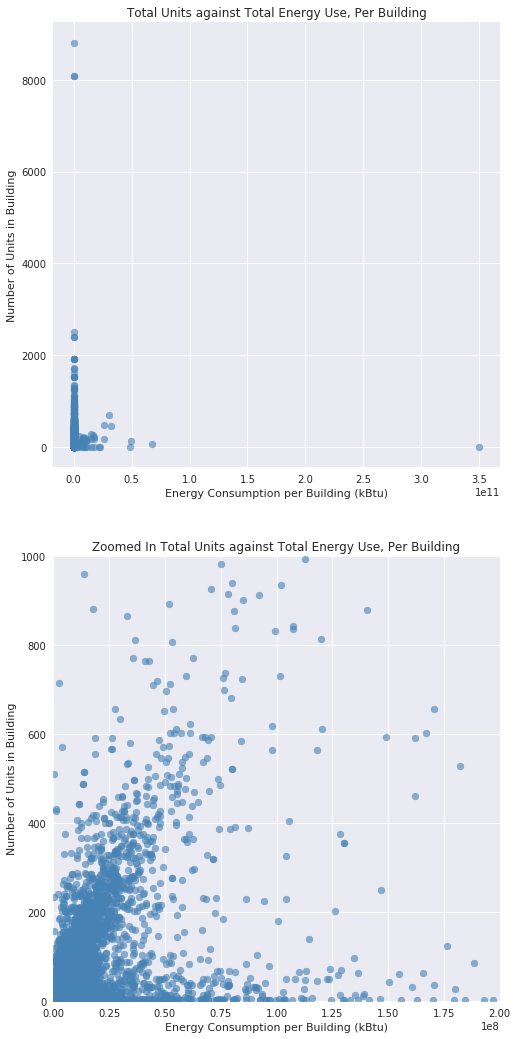

In [247]:
## multiplying area by energy/area to get total energy per building
bblnrgdataGPD['nrg'] = bblnrgdataGPD[\
    'Reported Property Floor Area'].astype(float) *\
                bblnrgdataGPD['Site EUI(kBtu/ft2)'].astype(float)

plt.figure(figsize=(8,18))

plt.subplot(211)
plt.title('Total Units against Total Energy Use, Per Building')
plt.scatter(bblnrgdataGPD.nrg, 
            bblnrgdataGPD.UnitsTotal, 
            alpha=0.6, 
            c='steelblue')
plt.xlabel('Energy Consumption per Building (kBtu)')
plt.ylabel('Number of Units in Building')


plt.subplot(212)
plt.title('Zoomed In Total Units against Total Energy Use, Per Building')
plt.scatter(bblnrgdataGPD.nrg, 
            bblnrgdataGPD.UnitsTotal,
            alpha=0.6,
            c='steelblue')
plt.xlabel('Energy Consumption per Building (kBtu)')
plt.ylabel('Number of Units in Building')
plt.xlim(0,0.2e9)
plt.ylim(0,1000)


**Figure 4:** For the top graph, it's almost impossible to see any trends since there appears to be some extreme outliers. When we zoom in the trend becomes apparent, and a linear relationship  (with a lot of noise) is visually represented. 

# The magic of log scales!

In [248]:
#cut the data
bblnrgdataGPD = bblnrgdataGPD[(bblnrgdataGPD.UnitsTotal>1)&(bblnrgdataGPD.UnitsTotal<1000)]
bblnrgdataGPD = bblnrgdataGPD[(bblnrgdataGPD.nrg>1e3)&(bblnrgdataGPD.nrg<1e10)]

Text(0.5,0,'Total Energy Use')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


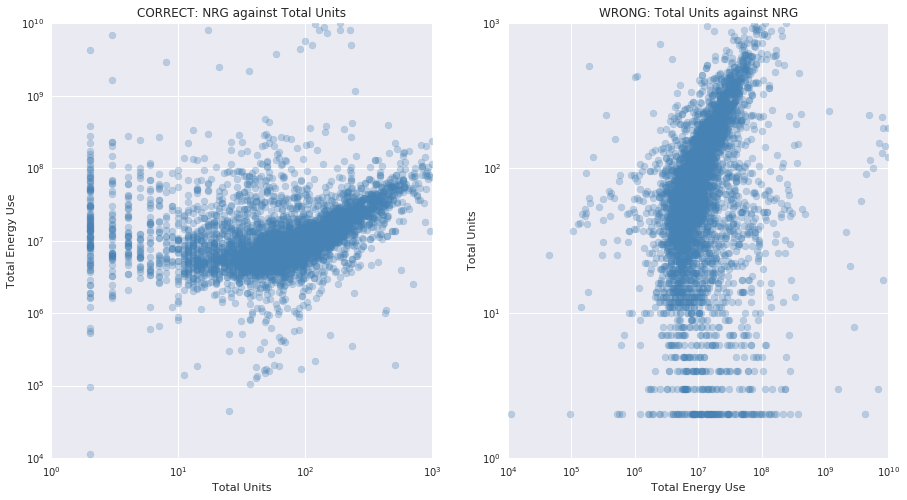

In [249]:
plt.figure(figsize=(15,8))

plt.subplot(121)
plt.title('CORRECT: NRG against Total Units')
plt.scatter(bblnrgdataGPD.UnitsTotal, #indep
            bblnrgdataGPD.nrg, #dep
           c='steelblue',
           alpha=0.3)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,1000)
plt.ylim(1e4,1e10)
plt.xlabel('Total Units')
plt.ylabel('Total Energy Use')

plt.subplot(122)
plt.title('WRONG: Total Units against NRG')
plt.scatter(bblnrgdataGPD.nrg, #indep
            bblnrgdataGPD.UnitsTotal, #dep
           c='steelblue',
           alpha=0.3)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1,1000)
plt.xlim(1e4,1e10)
plt.ylabel('Total Units')
plt.xlabel('Total Energy Use')

**Figure 6**: As you can see, the correct scatter plot (left) is when our Total Units is the independent variable, and total energy use is our dependent variable. This is because our hypothesis is that occupancy is driving energy use, not the other way around.  Notice that there appears to be a non-linear relationship in our plot with log-axes

# Fitting the data in log space:  

In [250]:
#need to transform nrg variable to log
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD.nrg)
bblnrgdataGPD['logUnits2'] = np.log10(bblnrgdataGPD.UnitsTotal)

mod1 = smf.ols('lognrg ~ logUnits2',data=bblnrgdataGPD).fit()
mod2 = smf.ols('logUnits2 ~ lognrg',data=bblnrgdataGPD).fit()

In [251]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     265.0
Date:                Thu, 29 Nov 2018   Prob (F-statistic):           5.57e-58
Time:                        13:28:49   Log-Likelihood:                -2854.5
No. Observations:                4624   AIC:                             5713.
Df Residuals:                    4622   BIC:                             5726.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.6627      0.024    280.699      0.000         6.616     6.709
logUnits2      0.2078      0.013     16.279      0.000         0.183     0.233
==============================================================================
Omnibus:                     1304.227   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12405.006
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                      10.734   Cond. No.                         8.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [252]:
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logUnits2   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     265.0
Date:                Thu, 29 Nov 2018   Prob (F-statistic):           5.57e-58
Time:                        13:28:49   Log-Likelihood:                -3380.8
No. Observations:                4624   AIC:                             6766.
Df Residuals:                    4622   BIC:                             6778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0493      0.113     -0.437      0.662        -0.271     0.172
lognrg         0.2609      0.016     16.279      0.000         0.230     0.292
==============================================================================
Omnibus:                      808.458   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1423.999
Skew:                          -1.119   Prob(JB):                    6.06e-310
Kurtosis:                       4.544   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,0,'Total Energy Use')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


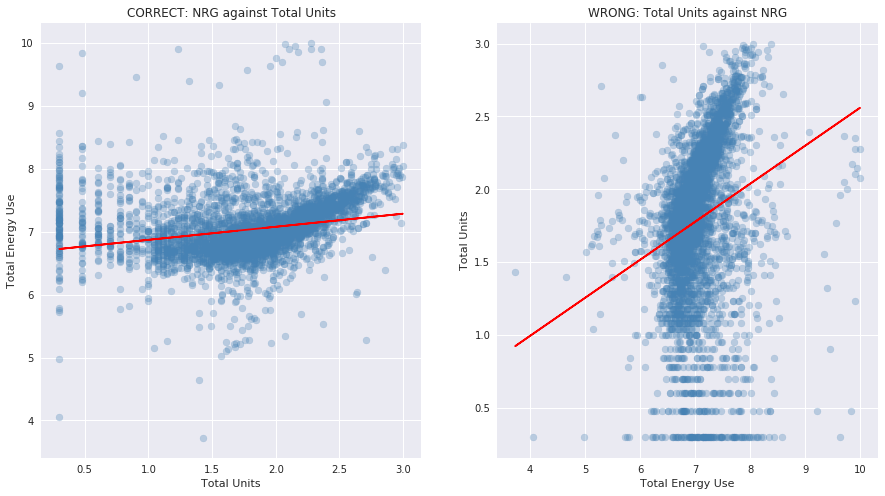

In [253]:
plt.figure(figsize=(15,8))

plt.subplot(121)
plt.title('CORRECT: NRG against Total Units')
plt.scatter(bblnrgdataGPD.logUnits2, #indep
            bblnrgdataGPD.lognrg, #dep
           c='steelblue',
           alpha=0.3)
plt.plot(bblnrgdataGPD.logUnits2,mod1.predict(bblnrgdataGPD),c='r')
plt.xlabel('Total Units')
plt.ylabel('Total Energy Use')

plt.subplot(122)
plt.title('WRONG: Total Units against NRG')
plt.scatter(bblnrgdataGPD.lognrg, #indep
            bblnrgdataGPD.logUnits2, #dep
           c='steelblue',
           alpha=0.3)
plt.plot(bblnrgdataGPD.lognrg,mod2.predict(bblnrgdataGPD),c='r')
plt.ylabel('Total Units')
plt.xlabel('Total Energy Use')

**Figure 7:**: Here, I've once again plotted both variations of Independent vs Dependent variables, even though we know which is the correct version (left). What's interesting is that our $R^2$ *statistic* is the same for both linear models: $0.054$. However, our *log-likelihood* is $-2854.5$ for the correct model vs $-3380.8$. In other words, the likelihood is greater (as expected) for the correct model than the incorrect model. This can be seen visually in the graphs above

# Second degree polynomial fit

In [254]:
bblnrgdataCut = bblnrgdataGPD.sort_values(by=['logUnits2'])
bblnrgdataCut['logunits_sq'] = bblnrgdataCut.logunits**2
mod3 = smf.ols('lognrg ~ logunits_sq + logUnits2',data=bblnrgdataCut).fit()
mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     574.1
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          2.06e-223
Time:                        13:28:50   Log-Likelihood:                -2470.3
No. Observations:                4624   AIC:                             4947.
Df Residuals:                    4621   BIC:                             4966.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       7.6469      0.040    189.005      0.000         7.568     7.726
logunits_sq     0.0820      0.003     28.903      0.000         0.076     0.088
logUnits2      -1.1852      0.050    -23.891      0.000        -1.283    -1.088
==============================================================================
Omnibus:                     1436.558   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24336.372
Skew:                           1.032   Prob(JB):                         0.00
Kurtosis:                      14.048   Cond. No.                         214.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'Total Energy Use (Log 10 kBtu)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


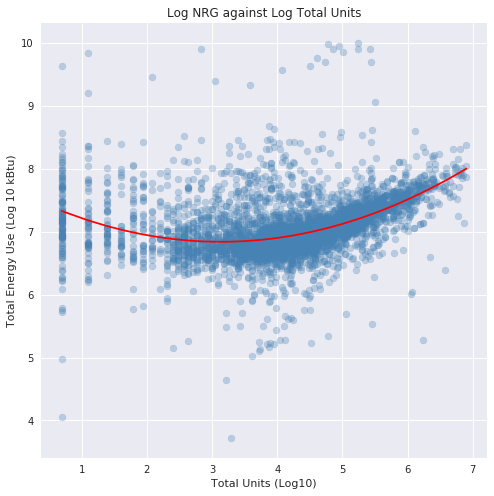

In [256]:
plt.figure(figsize=(8,8))

plt.title('Log NRG against Log Total Units')
plt.scatter(bblnrgdataCut.logunits, #indep
            bblnrgdataCut.lognrg, #dep
           c='steelblue',
           alpha=0.3)
plt.plot(bblnrgdataCut.logunits,mod3.predict(bblnrgdataCut),c='r')
plt.xlabel('Total Units (Log10)')
plt.ylabel('Total Energy Use (Log 10 kBtu)')


**Figure 8:** This model shows the fit of our polynomial model in log space. This shows that our polynomial ols function is visually a better fit than our simple line, and that is confirmed by our $R^2$ *statistic* of $0.254$. Our log-likelihood has also improved with a score of $-1651.0$

# Calculate the chi square and likelihood of your model

## Define a chisquare function

In [324]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones(data.shape)
    chisq = np.sum((data-model)**2/errors**2)
    return(chisq)    

## Error Calculation

In [258]:
#Calculate error for nrg since it's composed of two variables
error= np.sqrt(bblnrgdataCut['Site EUI(kBtu/ft2)']**2+bblnrgdataCut['Reported Property Floor Area']**2)

#errors on the measured quantities
bblnrgdataCut['errorsnrg'] = error/(bblnrgdataCut.nrg * np.log(10))
bblnrgdataCut['errorsunits'] = np.sqrt(bblnrgdataCut.UnitsTotal)/(bblnrgdataCut.UnitsTotal*np.log(10))


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with plt.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,BBL,UnitsTotal,YearBuilt,UnitsRes,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area,logarea,lognrg,logunits,nrg,logUnits2,logunits_sq,errorsnrg,errorsunits
3313,1.019900e+09,27,1909,27,"POLYGON ((994066.3934326172 234073.4490356445,...",0.1,53440.0,10.886315,3.727866,3.295837,5344.0,1.431364,10.862541,4.342945,0.08358


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


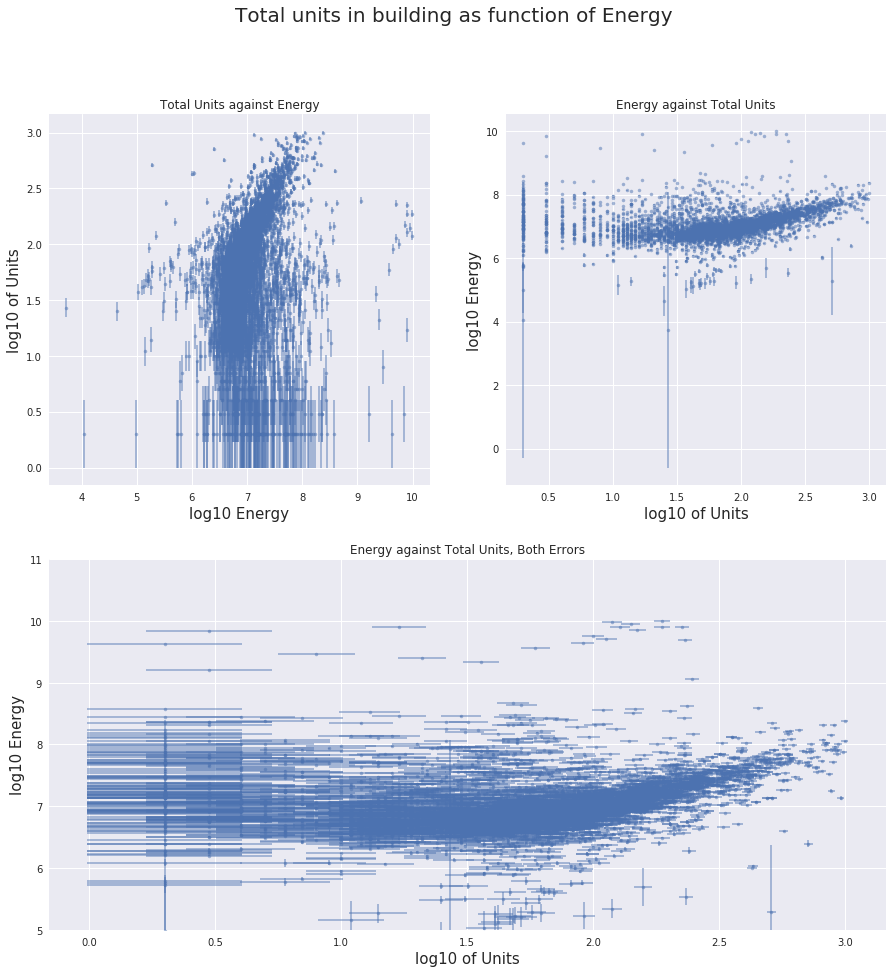

In [260]:
#I could also include errors for number of units
fig = plt.figure(figsize=(15,15))
plt.suptitle("Total units in building as function of Energy", fontsize=20)


ax = plt.subplot(221)
ax.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax.set_ylabel("log10 of Units", fontsize=15)
ax.set_xlabel("log10 Energy", fontsize=15)
ax.set_title("Total Units against Energy")



ax2 = plt.subplot(222)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)
ax2.set_title("Energy against Total Units")


ax4 = plt.subplot(212)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg,
            xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)
ax4.set_title("Energy against Total Units, Both Errors")


print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]

**Figure 7:** The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are plotting dimensionless quantities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Chi square Calculations
* **Compare between first two linear models to see which has better results. 
* **Calculate with and without errors


### calculate the degrees of freedom of this model

In [321]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(mod2.predict()) - mod2.df_model
print ("degrees of freedom:" , dof)

degrees of freedom: 4623.0


In [325]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2b(np.log10(bblnrgdataCut.UnitsTotal), mod2.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), mod2.predict(), 
            errors = bblnrgdataCut.errorsnrg) / float(dof)))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), mod2.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Units vs Energy residuals (no errors include): 0.28
Units vs Energy chi square per DOF w independent variable error only: 18365129.68
Units vs Energy chi square per DOF : 183.93


In [323]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), mod1.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), mod1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), mod1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Energy vs Units residuals (no errors include): 0.23
Energy vs Units chi square per DOF w independent variable error only: 272952397.56
Energy vs Units chi square per DOF : 146.16


### Interpretation of chi square calculations:
When not counting for errors, the two models have very similar results (0.28 & 0.23). However, when we add in our errors (indepependent variable only), the correct model's chi statistic is almost 15 times greater.


# Influence Plotting

**One more way of deciding which are our exogenous and which is our endogenous variables**

Text(0.5,1,'Units vs Energy Influence Plot')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


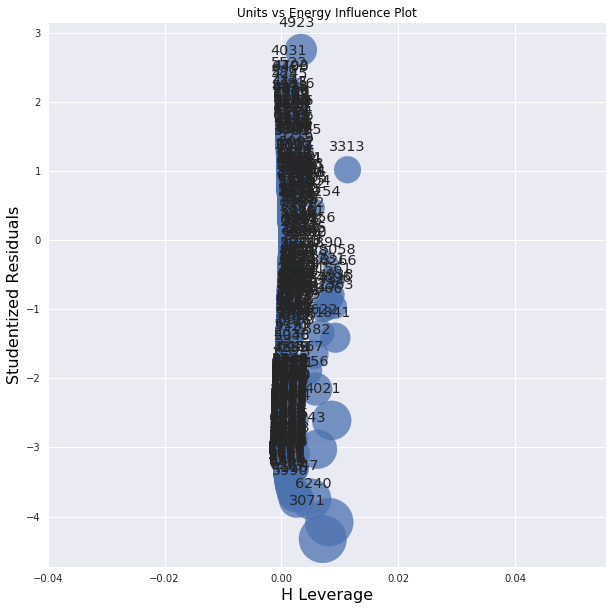

In [345]:
fig, ax = plt.subplots(figsize=(10,10))
sm.graphics.influence_plot(mod2, alpha  = 0.05, criterion="cooks", ax=ax);
ax.set_title('Units vs Energy Influence Plot')

Text(0.5,1,'Energy vs Units Influence Plot')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


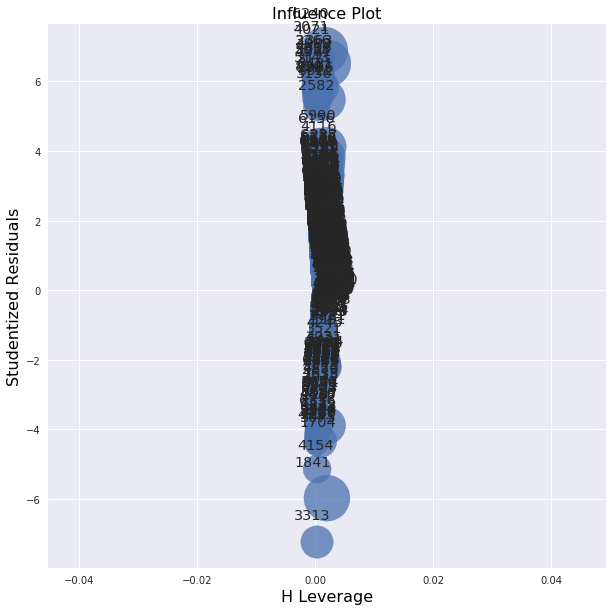

In [346]:
fig, ax2 = plt.subplots(figsize=(10,10))
sm.graphics.influence_plot(mod1, alpha  = 0.05, criterion="cooks", ax=ax2)
ax.set_title('Energy vs Units Influence Plot', fontsize=20)

**Figure 10:** The two graphs above show that both influence plots are both tall and narrow. However, when we're looking at Energy vs. Units, our vertical distribution is much greater. This is further proof of this model being a better selection for our data, since we want a wider rander in our exogenous variable (energy in this case) for our model to fit to.  


# Comparing the linear and curve fit with Likelihood Ratio LR test; $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


In [351]:
mod3.compare_lr_test(mod1)

(768.37645926809728, 4.0528591466552818e-169, 1.0)

According to this test, we can **reject the null hypothesis** that our simple linear model (mod1) is better than our more complex quadratic model (mod3). This is because we have a large LR stat of $768$ with a p value of $~0$. Therefore, our quadratic model fits our data the best.